In [1]:
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [12]:
def summarize(model_path):
    
    checkpt_dir = '/nfs0/BB/Hendrix_Lab/valejose/bioseq2seq/checkpoints/coding_noncoding/'
    checkpoint = torch.load(checkpt_dir+model_path, map_location='cpu')
    opts = checkpoint['opt']
    print(f'Loaded model {model_path} with parent {opts.checkpoint} and mode {opts.mode}')
    return checkpoint

checkpoint = summarize('Apr09_20-21-59/_step_6500.pt')
#checkpoint = summarize('Apr07_21-35-02/_step_9000.pt')


Loaded model Apr09_20-21-59/_step_6500.pt with parent None and mode bioseq2seq


In [13]:
def show_single_filter(gf):
    # gf: global filter: (h, h // 2 + 1, 2)
    print(gf.shape,gf.dtype)
    h = gf.size(0)
    w = 200 //2 +1
    if len(gf.shape) == 3:
        gf_complex = torch.view_as_complex(gf.permute(0,2,1).contiguous()).T
    else:
        gf_complex = gf
    #gf_spatial = torch.fft.irfft2(gf_complex, dim=(0,1), s=(h,w))
    #gf_complex = torch.fft.fft2(gf_spatial, dim=(0,1))
    #gf_complex = torch.fft.fftshift(gf_complex, dim=(0,1))
    gf_abs = gf_complex.abs()
    return gf_abs

n_viz_channel = 8
global_filters = []
has_next = True
i_layer = 0
while has_next:
    layer = f'encoder.fnet.{i_layer}.global_filter'
    if layer in checkpoint['model']:
        weight = checkpoint['model'][layer]
        global_filters.append(show_single_filter(weight)[None])
        i_layer +=1
    else:
        has_next = False
        print("False at", i_layer)
    


torch.Size([33, 2, 50]) torch.float32
torch.Size([76, 64]) torch.complex64
torch.Size([33, 2, 50]) torch.float32
torch.Size([76, 64]) torch.complex64
torch.Size([33, 2, 50]) torch.float32
torch.Size([76, 64]) torch.complex64
torch.Size([33, 2, 50]) torch.float32
torch.Size([76, 64]) torch.complex64
False at 8


In [14]:
%matplotlib inline


In [15]:
def approximate_index(period,filter_size):
    frequency = 1.0 / period
    index = int(2*frequency*filter_size)
    return index

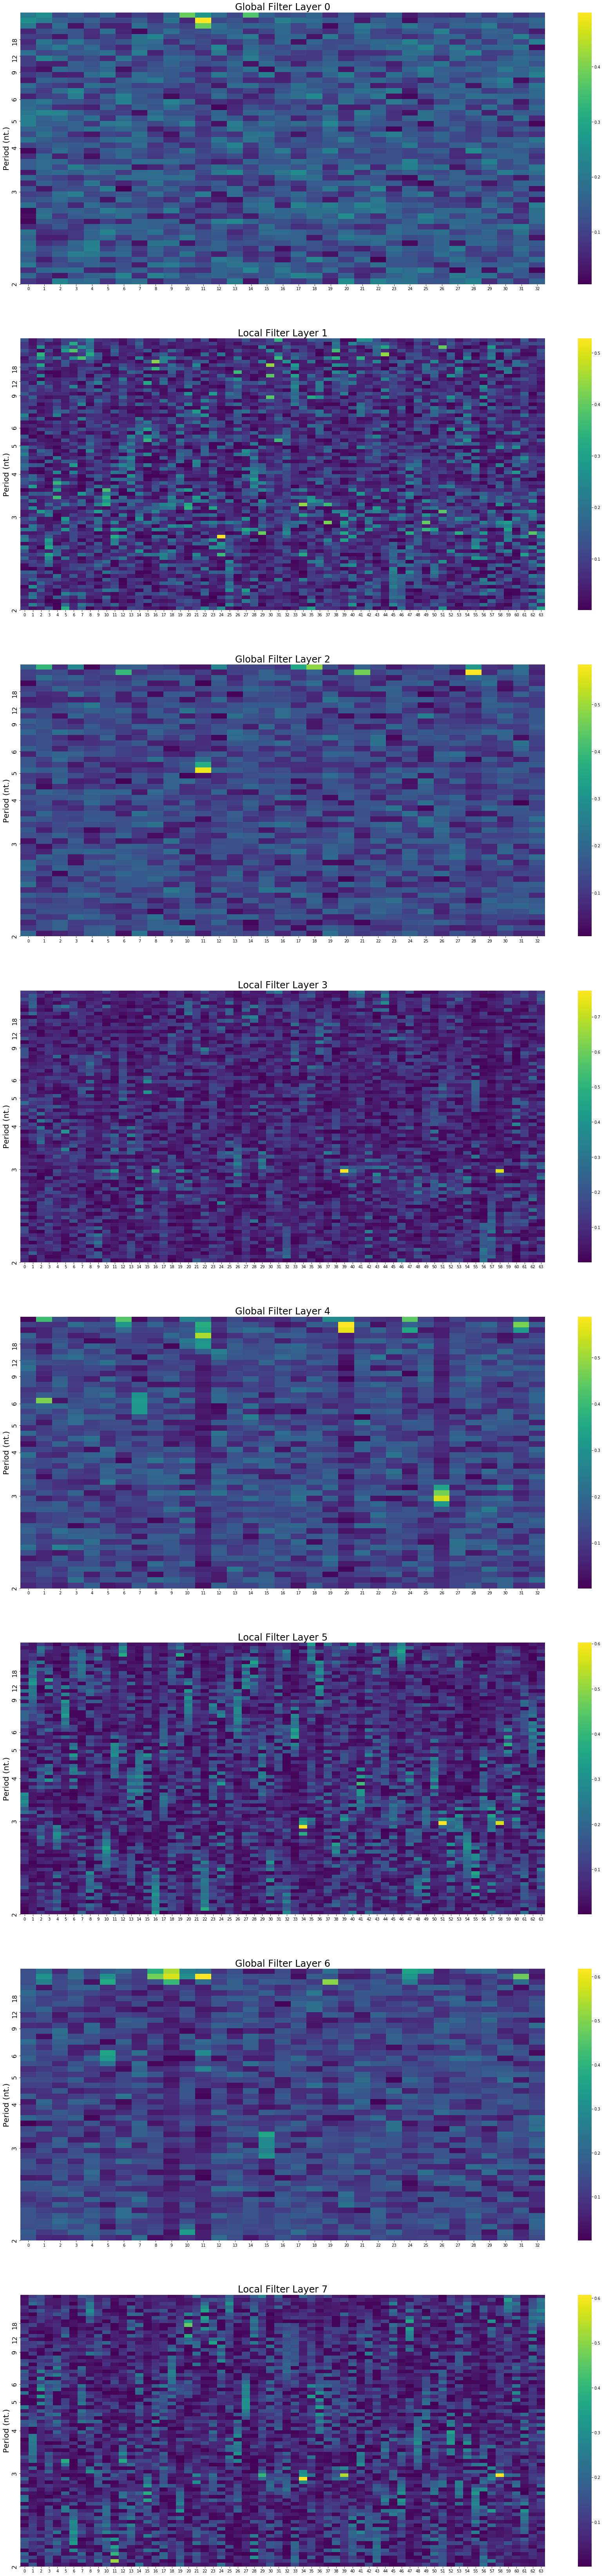

In [16]:
import numpy as np
import seaborn as sns
import torch.nn.functional as F

def plot_filters(global_filter_list):
    
    periods = [18,12,9,6,5,4,3,2]
    fig, axs = plt.subplots(len(global_filter_list),1,figsize=(30,120))
    
    for i in range(len(global_filter_list)):
        gf = global_filter_list[i].numpy().squeeze()
        gf = gf / np.linalg.norm(gf,axis=0)
        
        if i % 2 == 0 :
            title = f"Global Filter Layer {i}"
        else:
            title = f"Local Filter Layer {i}"
            
        g = sns.heatmap(data=gf, cmap='viridis',ax=axs[i])
        g.set_title(title,fontsize=24)
        tick_locs =[approximate_index(p,gf.shape[0]) for p in periods]
        g.set_ylabel("Period (nt.)",fontsize=20)
        g.set_yticks(tick_locs)
        g.set_yticklabels(periods,fontsize=16)
        
plot_filters(global_filters)
